<div style="text-align: center;">
<h1>Reel Realities: How Gender and Age Shape Success Across Box Office and Streaming Platforms</h1>
</div>

### <u>Imports</u>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import plotly.graph_objects as go
import warnings
import transformers

from src.data.dataloader import (
    CMUDatasetLoader, IMDBDatasetLoader, KaggleDatasetLoader, NumbersDatasetLoader, BechdelDatasetLoader, DialogueDatasetLoader, ZeroShotResultsLoader, ClusteringResultsLoader)
from src.utils.EDA_utils import EDA
from src.scripts.streaming import get_streaming_dataframe
import src.models.regression as regression
import src.utils.data_utils as data_utils
import src.utils.evaluation_utils as evaluation_utils

# Suppress specific FutureWarnings about is_sparse being deprecated
warnings.filterwarnings(action="ignore", category=FutureWarning, module="sklearn", message=".*is_sparse is deprecated.*")

### 1. <u>Data cleaning and pre-processing</u>

#### 1.1 CMU Dataset

We will use three files of the CMU dataset:
1. "plot_summaries.txt" gives us the plots of the movies.
2. "movie.metadata.tsv" gives us information about the languages, countries, and genres of the movies.
3. "character.metadata.tsv" gives us information about actors and the characters they play.

In [2]:
directory = "data"
CMU_loader = CMUDatasetLoader(directory)
plot_summaries_df = CMU_loader.load_plot_summaries()

print(f"The plot summaries dataframe has {len(plot_summaries_df):,} values.")

The plot summaries dataframe has 42,303 values.


In [3]:
null_id = plot_summaries_df["Wikipedia_movie_ID"].isnull().sum()
empty_id = plot_summaries_df[plot_summaries_df["Wikipedia_movie_ID"] == ""]["Wikipedia_movie_ID"].sum()
null_plot = plot_summaries_df["Plot Summaries"].isnull().sum()
empty_plot = plot_summaries_df[plot_summaries_df["Plot Summaries"] == ""]["Plot Summaries"].sum()

print(f"Number of null values in 'Wikipedia_movie_ID': {null_id}")
print(f"Number of empty values in 'Wikipedia_movie_ID': {empty_id}")
print(f"Number of null values in 'Plot Summaries': {null_plot}")
print(f"Number of empty values in 'Plot Summaries': {empty_plot}")

Number of null values in 'Wikipedia_movie_ID': 0
Number of empty values in 'Wikipedia_movie_ID': 0
Number of null values in 'Plot Summaries': 0
Number of empty values in 'Plot Summaries': 0


In [4]:
movie_metadata_df = CMU_loader.load_movie_metadata()
print(f"The movie metadata dataframe has {len(movie_metadata_df):,} values.")

The movie metadata dataframe has 81,741 values.


In [5]:
movie_metadata_df["Movie_name"] = (movie_metadata_df["Movie_name"]
                    .str.strip()  #Remove leading/trailing whitespace
                    .str.lower()  #Convert to lowercase
                    .replace("", np.nan)  #Replace empty strings with NaN
                   )

In [6]:
# Movie languages, countries, and genres are formatted as a dictionary, but they are actually a string.
# We convert them to comma seperated strings. 

column_names_to_clean = ["Movie_countries", "Movie_languages", "Movie_genres"]
movie_metadata_df = data_utils.convert_dicts_to_strings(movie_metadata_df, column_names_to_clean)

# Cleaning the strings
movie_metadata_df = data_utils.clean_string_columns(movie_metadata_df, column_names_to_clean)

In [7]:
# There are inconsistencies in the date format: some rows have the date as year only, others as year-month, and some as year-month-day. 
# We convert them all to the year format only since the month and day are not relevant to our analysis.
movie_metadata_df, date_pattern_summary = data_utils.standardize_dates(movie_metadata_df, "Movie_release_date")
print("Pattern Summary:\n", date_pattern_summary)

Pattern Summary:
                        Pattern  Count
0       Full Date (YYYY-MM-DD)  39373
1             Year Only (YYYY)  32172
2                      Missing   6902
3  Year & Month Date (YYYY-MM)   3294


In [8]:
# Looking at the percentage of null values in the dataset
n_null_movie_metadata = ((movie_metadata_df.isnull().sum() / len(movie_metadata_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"movie_metadata_df:\n{n_null_movie_metadata}"
)

Percentage of null values per column:
movie_metadata_df:
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           8.44%
Movie_box_office_revenue    89.72%
Movie_runtime               25.02%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres                 0.00%
dtype: object


In [9]:
character_metadata_df = CMU_loader.load_character_metadata()

In [10]:
character_metadata_df["Actor_name"]= character_metadata_df["Actor_name"].fillna("unknown").str.lower()

# Ensures that the date columns are correctly interpreted as datetime objects in pandas. 
character_metadata_df["Movie_release_date"] = pd.to_datetime(character_metadata_df["Movie_release_date"], errors="coerce").dt.date
character_metadata_df["Actor_date_of_birth"] = pd.to_datetime(character_metadata_df["Actor_date_of_birth"], errors="coerce").dt.date

# Drop rows where "Movie_release_date" or "Actor_date_of_birth" is NaT
character_metadata_df.dropna(subset=["Movie_release_date", "Actor_date_of_birth"], inplace=True)

# Calculate Actor_age_at_movie_release if missing and data is available
character_metadata_df["Actor_age_at_movie_release"] = character_metadata_df.apply(
    lambda row: (row["Movie_release_date"] - row["Actor_date_of_birth"]).days // 365 if pd.isnull(row["Actor_age_at_movie_release"]) else row["Actor_age_at_movie_release"],
    axis=1
)

In [11]:
print(f"Movies without actor gender data: {character_metadata_df['Actor_gender'].isnull().sum()}") 

Movies without actor gender data: 892


We therefore drop the movies with no information on the gender of the actors.

In [12]:
character_metadata_df.dropna(subset=["Actor_gender"], inplace=True)

Now, let's group the actors together by creating a *Cast* column on the *movie_metadata_df*. 

In [13]:
cast_per_movie = character_metadata_df.groupby("Freebase_movie_ID")["Actor_name"].apply(lambda x: ", ".join(x)).reset_index()
cast_per_movie = cast_per_movie.rename(columns={"Actor_name": "Cast"})

movie_metadata_df = movie_metadata_df.merge(cast_per_movie, on="Freebase_movie_ID", how="left")

In [14]:
missing_cast_count = movie_metadata_df["Cast"].isna().sum()
total_movies = len(movie_metadata_df)
print(f"Movies without actor data: {missing_cast_count} out of {total_movies} ({missing_cast_count / total_movies * 100:.2f}%)")

Movies without actor data: 48556 out of 81741 (59.40%)


We decide to drop the movies without actor data since it is one of the most important features of our study. 

In [15]:
movie_metadata_df = movie_metadata_df.dropna(subset = ["Cast"])

In [16]:
# Create columns for male, female actor counts
actor_counts = character_metadata_df.groupby("Freebase_movie_ID")["Actor_gender"].value_counts().unstack(fill_value=0)
actor_counts = actor_counts.rename(columns={"M": "Male_actors", "F": "Female_actors"})

# Ensure all columns are present (set missing columns to 0 if necessary)
for col in ["Male_actors", "Female_actors"]:
    if col not in actor_counts.columns:
        actor_counts[col] = 0

actor_counts = actor_counts.reset_index()

# Merge actor counts with the movie_metadata_df DataFrame
movie_metadata_df = movie_metadata_df.merge(actor_counts, on="Freebase_movie_ID", how="left")

# Fill NaN values with 0 
movie_metadata_df[["Male_actors", "Female_actors"]] = movie_metadata_df[["Male_actors", "Female_actors"]].fillna(0)

In [17]:
# Calculate the percentage of female actors in each movie and round to two decimal places
movie_metadata_df["Female_actor_percentage"] = (
    (movie_metadata_df["Female_actors"] / 
     (movie_metadata_df["Female_actors"] + movie_metadata_df["Male_actors"])) * 100
).round(2)

#### 1.2 IMDB Dataset

We will use two IMDB datasets to decribe movies:
1. "title.ratings.tsv" gives us the ratings of the movies as voted by viewers. 
2. "title.basics.tsv", indexes into "title.ratings.tsv" using a alphanumeric unique identifier of the title. It gives general information about the movie such as runtime, release date and adult rating.
3. "title.crew.tsv", indexes into the previous two using the same alphanumeric unique identifier of the title. It gives information on the directors and writers of the movie.

Reference:
Internet Movie Database. (2024). IMDb non-commercial datasets. Retrieved from https://developer.imdb.com/non-commercial-datasets/

In [18]:
# Loading the IMDB datasets.
IMDB_loader = IMDBDatasetLoader(directory)
IMDB_ratings_df = IMDB_loader.load_ratings()

IMDB_basics_df = IMDB_loader.load_basics()

IMDB_crew_df = IMDB_loader.load_crew()

In [19]:
# Checking the lengths of the datasets
print(f"Length of IMDB_ratings_df: {len(IMDB_ratings_df):,}\n"
      f"Length of IMDB_basics_df: {len(IMDB_basics_df):,}\n"
      f"Length of IMDB_crew_df: {len(IMDB_crew_df):,}")

Length of IMDB_ratings_df: 1,498,616
Length of IMDB_basics_df: 697,175
Length of IMDB_crew_df: 10,571,537


Before dealing with the null values we will merge the dataframes together using the alphanumeric unique identifier.

In [20]:
# Merging all three datasets.
IMDB_merged_df = pd.merge(IMDB_ratings_df, IMDB_basics_df, how="inner", left_on="tconst", right_on="tconst")
IMDB_merged_df = pd.merge(IMDB_merged_df, IMDB_crew_df, how="inner", on="tconst")

In [21]:
print(f"The resulting merged dataframe has length: {len(IMDB_merged_df):,}.")

The resulting merged dataframe has length: 319,293.


Formatting the strings appropriately.

In [22]:
IMDB_merged_df = data_utils.clean_string_columns(IMDB_merged_df, ["Original_title", "Primary_title"])

We can now look at null values in the merged IMDB dataframe.

In [23]:
# Checking the percentage of null values in the dataset.
n_null_IMDB = ((IMDB_merged_df.isnull().sum() / len(IMDB_merged_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"IMDB_ratings_df:\n{n_null_IMDB}"
)

Percentage of null values per column:
IMDB_ratings_df:
tconst               0.00%
Average_ratings      0.00%
Num_votes            0.00%
Title_type           0.00%
Primary_title        0.00%
Original_title       0.00%
Is_adult             0.00%
Start_year           0.01%
End_year           100.00%
Movie_runtime        9.98%
Movie_genres         3.26%
Directors            0.98%
Writers             12.30%
dtype: object


The end year is always missing. Other than that the proportion of missing values is very small (< 12%). End year is always null for movies and only makes sense for TV shows. It can thus be dropped. We can also drop the titleType column since we know they are all movies after the filtering that was done above.

In [24]:
# Dropping unnecessary columns.
IMDB_merged_df = IMDB_merged_df.drop(columns=["End_year", "Title_type"], axis=1)

print(f"The resulting dataframe has {len(IMDB_merged_df):,} rows.")

The resulting dataframe has 319,293 rows.


We will use ratings from the IMDB dataset during our study. However, these ratings are based on viewer votes. Initially we thought of discarding rows with too few votes. However, there could be a link between number of votes and number of views of a movie (although definitely not a direct one). We thus decided to keep all rows for the analysis.

#### 1.3 Merging the datasets

##### 1.3.1 Merging IMDB and CMU Movies

In [25]:
# Merging on the original title.
merge1 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on=["Original_title", "Start_year"],  right_on=["Movie_name", "Movie_release_date"])
# Merging on the primary title.
merge2 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on=["Primary_title", "Start_year"], right_on=["Movie_name", "Movie_release_date"])

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
movie_df = pd.concat([merge1, merge2]).drop_duplicates(subset=["tconst"]).reset_index(drop=True)

print(f"The resulting dataframe has {len(movie_df):,} rows.")

The resulting dataframe has 22,044 rows.


Some columns appear twice. Let's take a look at the proportion of null values in each duplicate column.

In [26]:
n_null_movie = (movie_df.isnull().sum()/len(movie_df)).apply(lambda x:f"{x:.2%}")

print(f"Percentage of null values per column:\n{n_null_movie}")

Percentage of null values per column:
tconst                       0.00%
Average_ratings              0.00%
Num_votes                    0.00%
Primary_title                0.00%
Original_title               0.00%
Is_adult                     0.00%
Start_year                   0.00%
Movie_runtime_x              3.11%
Movie_genres_x               0.61%
Directors                    0.16%
Writers                      2.41%
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           0.00%
Movie_box_office_revenue    72.33%
Movie_runtime_y             10.31%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres_y               0.00%
Cast                         0.00%
Female_actors                0.00%
Male_actors                  0.00%
Female_actor_percentage      0.00%
dtype: object


We can see:
- Movie_runtime_x and Movie_runtime_y have 6.02% and 11.58% missing values respectively. We will combine the non null values from both these columns into a new column called runtimeMinutes and then drop the previous two columns. 
- Movie_genres_x has 1.54% missing values against 0.00% missing values for Movie_genres_y. Furthermore Movie_genres_y is from the CMU dataset and seems more complete. We will thus drop the genres_x column.

In [27]:
# Combining all non-null values from Movie_runtime_x and Movie_runtime_y into runtimeMinutes.
movie_df["Movie_runtime"] = movie_df["Movie_runtime_x"].combine_first(movie_df["Movie_runtime_y"])

# Dropping the unnecessary columns.
movie_df.drop(columns=["Movie_runtime_x", "Movie_runtime_y", "Movie_genres_x"], inplace=True)

Let's now see if Movie_name, originalTitle and primaryTitle are all necessary or if there are any redundancies.

In [28]:
test1 = movie_df["Movie_name"] == movie_df["Primary_title"]  
test2 = movie_df["Movie_name"] == movie_df["Original_title"]

# Checking if there are any movies for which Movie_name is not either in Primary_title or Original_title
print(f"There are {(~(test1 | test2)).sum().item()} movies for which Movie_name is in neither Primary_title ot Original_title.")

There are 0 movies for which Movie_name is in neither Primary_title ot Original_title.


We can see the Movie_name column is redundant as its information is either in primaryTitle or in originalTitle. We can thus drop this column.

In [29]:
movie_df.drop(columns="Movie_name", inplace=True)

We can now also drop movie identifier columns Freebase_movie_ID (as everything is already indexed). We will need tconst later on so we keep it.

In [30]:
movie_df.drop(columns=["Freebase_movie_ID"], inplace=True)

To connect this with the plot_summaries_df, we perform a left merge.

In [31]:
movie_df = pd.merge(movie_df, plot_summaries_df, on="Wikipedia_movie_ID", how="left")

Finally, we can drop Wikipedia_movie_ID, which is also a movie identifier column.

In [32]:
movie_df.drop(columns="Wikipedia_movie_ID", inplace=True)

In [33]:
movie_df["Movie_release_date"] = movie_df["Movie_release_date"].astype(float)

In [34]:
# Check for duplicates in movie_df
movie_df.duplicated(subset=['Primary_title', 'Original_title', 'Movie_release_date']).sum()

109

In [35]:
# Get the index of the max Num_votes for duplicated rows
idx = movie_df.groupby(['Primary_title', 'Original_title', 'Movie_release_date'])['Num_votes'].idxmax()

movie_df = movie_df.loc[idx]

movie_df.reset_index(drop=True, inplace=True)

# Check again if duplicated rows are still here
movie_df.duplicated(subset=['Primary_title', 'Original_title', 'Movie_release_date']).sum()

0

##### 1.3.3 Merging Kaggle and The numbers datasets to the rest

We have a problem, a lot of missing values(NaN or 0) in Movie box office revenue in movie_df and no production budget included. 
These two new datasets include information about movies revenue and budget and other attributes which are crucial for our analysis.

- `Kaggle_df`: Contains important details about movies, including budgets, genres, and revenue.
- `TheNumbers_df`: Provides detailed financial data, focusing on budget and box office gross both domestically and worldwide.

In [36]:
Kaggle_df = KaggleDatasetLoader(directory).load_kaggle()
TheNumbers_df = NumbersDatasetLoader(directory).load_numbers()

Quickly view the structure of the dataframes to understand the data types and confirm data has loaded correctly

In [37]:
Kaggle_df.head()

,budget,genres,original_title,popularity,production_companies,production_countries,revenue
0,237000000.0,Action Adventure Fantasy Science Fiction,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.787965e+09
1,300000000.0,Adventure Fantasy Action,Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",9.610000e+08
2,245000000.0,Action Adventure Crime,Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",8.806746e+08
3,250000000.0,Action Crime Drama Thriller,The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.084939e+09
4,260000000.0,Action Adventure Science Fiction,John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.841391e+08


In [38]:
# Clean and convert financials to float for consistency with the movie_df
TheNumbers_df = data_utils.clean_currency_columns(TheNumbers_df, ["production_budget", "domestic_gross", "worldwide_gross"])

In [39]:
TheNumbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


We now perform an outer merge to include all records from both datasets, aligning them based on movie titles.


In [40]:
# Normalize the title columns for case insensitive matching
Kaggle_df = data_utils.clean_string_columns(Kaggle_df, ["original_title"])
TheNumbers_df = data_utils.clean_string_columns(TheNumbers_df, ["movie"])

# Merge both dataframes on the title columns
merged_df = pd.merge(Kaggle_df, TheNumbers_df, left_on="original_title", right_on="movie", how="outer")

##### Post-merge cleaning

We create the main financial columns ("movie_budget" and "movie_revenue") by selecting non-null and non-zero values, prioritizing data from TheNumbers dataset when available.


In [41]:
merged_df["movie_budget"] = np.where((merged_df["production_budget"].notna() & (merged_df["production_budget"] != 0)),
                                     merged_df["production_budget"],
                                     merged_df["budget"])

merged_df["movie_revenue"] = np.where((merged_df["worldwide_gross"].notna() & (merged_df["worldwide_gross"] != 0)),
                                      merged_df["worldwide_gross"],
                                      merged_df["revenue"])

# Drop the original columns that were merged into new ones
merged_df.drop(columns=["budget", "revenue", "production_budget", "worldwide_gross", "movie"], inplace=True)

Filter out movies where both budget and revenue data are missing or zero, as they do not provide value for financial analysis.


In [42]:
# Create a mask where both columns are either zero or NaN
mask = (
    (merged_df["movie_budget"].isna() | (merged_df["movie_budget"] == 0)) &
    (merged_df["movie_revenue"].isna() | (merged_df["movie_revenue"] == 0))
)

# Apply the mask and drop those rows
df_filtered = merged_df[~mask]

In [43]:
print("The number of available and relevant movie budget and revenue information is " + str(df_filtered["movie_budget"].size))

df_filtered.head()

The number of available and relevant movie budget and revenue information is 6085


,genres,original_title,popularity,production_companies,production_countries,id,release_date,domestic_gross,movie_budget,movie_revenue
0,Action Adventure Fantasy Science Fiction,avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.0,"Dec 18, 2009",760507625.0,425000000.0,2.776345e+09
1,Adventure Fantasy Action,pirates of the caribbean: at world's end,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",NaN,NaN,NaN,300000000.0,9.610000e+08
2,Action Adventure Crime,spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",10.0,"Nov 6, 2015",200074175.0,300000000.0,8.796209e+08
3,Action Crime Drama Thriller,the dark knight rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",11.0,"Jul 20, 2012",448139099.0,275000000.0,1.084439e+09
4,Action Adventure Science Fiction,john carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",14.0,"Mar 9, 2012",73058679.0,275000000.0,2.827781e+08


Two merging strategies are employed here to maximize the potential for matching records across the datasets:

Original Title Merge: Merging based on the Original_title from movie_df to the original_title from df_filtered to catch the most direct title matches. 

Primary Title Merge: Using Primary_title as an alternative matching criterion, knowing that some movies might be listed under alternate titles.


In [44]:
# Convert the 'Release_Date' column to datetime
df_filtered['release_date'] = pd.to_datetime(df_filtered['release_date'])

# Extract the year from the datetime
df_filtered['release_date'] = df_filtered['release_date'].dt.year

In [45]:
# Normalize the title columns for case-insensitive matching
movie_df["Original_title"] = movie_df["Original_title"].str.strip().str.lower()
movie_df["Primary_title"] = movie_df["Primary_title"].str.strip().str.lower()

# Merging on the original title.
merge1 = pd.merge(movie_df, df_filtered, how="inner", left_on=["Original_title", "Movie_release_date"], right_on=["original_title", "release_date"])
# Merging on the secondary title.
merge2 = pd.merge(movie_df, df_filtered, how="inner", left_on=["Primary_title", "Movie_release_date"], right_on=["original_title", "release_date"])

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
final_df = pd.concat([merge1, merge2]).drop_duplicates(subset=["tconst"]).reset_index(drop=True)

# Filter out movies where revenue data is missing or zero and prioritize initial revenue
final_df["final_movie_revenue"] = np.where(
    (final_df["Movie_box_office_revenue"].notna() & (final_df["Movie_box_office_revenue"] != 0)),
    final_df["Movie_box_office_revenue"],
    final_df["movie_revenue"]
)

final_df.drop(columns=["Movie_box_office_revenue", "domestic_gross", "movie_revenue", "original_title", "genres", "id", "release_date"], inplace=True, errors="ignore")

# Renaming the columns to follow the convention
rename_columns = {"popularity":"Popularity", 
                  "production_companies":"Production_companies", 
                  "prodcution_countries":"Production_countries",
                  "movie_budget":"Movie_budget",
                  "final_movie_revenue":"Final_movie_revenue",
                  "Movie_genres_y":"Movie_genres"}

final_df.rename(columns=rename_columns, inplace=True)


print(f"The resulting dataframe has {len(final_df):,} rows.")
final_df.head()

The resulting dataframe has 2,371 rows.


,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,Female_actors,Male_actors,Female_actor_percentage,Movie_runtime,Plot Summaries,Popularity,Production_companies,production_countries,Movie_budget,Final_movie_revenue
0,tt0147800,7.3,402271,10 things i hate about you,10 things i hate about you,0,1999,nm0432627,"nm0527581,nm0809006,nm0000636",1999.0,...,6,7,46.15,97,"Cameron James , a new student at Padua Stadium...",54.550275,"[{""name"": ""Mad Chance"", ""id"": 1757}, {""name"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",13000000.0,53478166.0
1,tt0211181,4.8,40166,102 dalmatians,102 dalmatians,0,2000,nm0510674,"nm0807977,nm0118649,nm0716391,nm0879318,nm0925276",2000.0,...,2,5,28.57,100,"After three years in prison, Cruella de Vil ha...",9.895061,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",85000000.0,183611771.0
2,tt0360323,6.3,7052,10th & wolf,10th & wolf,0,2006,nm0604263,"nm0604263,nm0824481",2006.0,...,2,8,20.00,107,"Tommy is the son of a Mafia hitman, who, after...",3.942464,"[{""name"": ""Thinkfilm"", ""id"": 446}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",8000000.0,143782.0
3,tt0050083,9.0,892430,12 angry men,12 angry men,0,1957,nm0001486,nm0741627,1957.0,...,0,14,0.00,96,The story begins in a courtroom where an 18-ye...,59.259204,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",340000.0,1000000.0
4,tt1160368,5.6,30914,12 rounds,12 rounds,0,2009,nm0001317,nm2896816,2009.0,...,4,11,26.67,108,A sting operation to capture notorious arms de...,15.661350,"[{""name"": ""The Mark Gordon Company"", ""id"": 155...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",20000000.0,18184083.0


### 2. Our success metric

#### Financial Analysis

##### Calculating Return on Investment (ROI)

To provide insights into the financial success of the movies, we calculate the Return on Investment (ROI). This metric is derived by comparing the movie"s final revenue to its budget.

- **Condition**: Ensure that both `movie_budget` and `final_movie_revenue` are non-zero and non-null to avoid division errors and ensure data integrity


In [46]:
final_df = evaluation_utils.calculate_roi(final_df, "Movie_budget", "Final_movie_revenue")
print("There is now " + str(final_df["Final_movie_revenue"].size) + " movies to work with in the financial success analysis")

There is now 2364 movies to work with in the financial success analysis


#### Data Normalization and Scaling

Given the varied scales of ratings and ROI, we standardize these features to a common scale using both Standard and Min-Max scalers. 

In [47]:
# Initialize scalers
final_df = evaluation_utils.scale_features(final_df)

#### Weighted Success Metric

To evaluate overall movie success, we calculate a weighted sum of normalized ratings and ROI, assigning double the weight to ROI given its financial significance in assessing success.

In [48]:
# Calculate movie success which is a weighted sum choosing that the ROI feature will have double the importance of ratings
#final_df = evaluation_utils.calculate_weighted_success(final_df, 0.67)

final_df.head()

,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,Female_actor_percentage,Movie_runtime,Plot Summaries,Popularity,Production_companies,production_countries,Movie_budget,Final_movie_revenue,ROI,Normalized_Rating
0,tt0147800,7.3,402271,10 things i hate about you,10 things i hate about you,0,1999,nm0432627,"nm0527581,nm0809006,nm0000636",1999.0,...,46.15,97,"Cameron James , a new student at Padua Stadium...",54.550275,"[{""name"": ""Mad Chance"", ""id"": 1757}, {""name"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",13000000.0,53478166.0,3.113705,0.73
1,tt0211181,4.8,40166,102 dalmatians,102 dalmatians,0,2000,nm0510674,"nm0807977,nm0118649,nm0716391,nm0879318,nm0925276",2000.0,...,28.57,100,"After three years in prison, Cruella de Vil ha...",9.895061,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",85000000.0,183611771.0,1.160138,0.48
2,tt0360323,6.3,7052,10th & wolf,10th & wolf,0,2006,nm0604263,"nm0604263,nm0824481",2006.0,...,20.00,107,"Tommy is the son of a Mafia hitman, who, after...",3.942464,"[{""name"": ""Thinkfilm"", ""id"": 446}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",8000000.0,143782.0,-0.982027,0.63
3,tt0050083,9.0,892430,12 angry men,12 angry men,0,1957,nm0001486,nm0741627,1957.0,...,0.00,96,The story begins in a courtroom where an 18-ye...,59.259204,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",340000.0,1000000.0,1.941176,0.90
4,tt1160368,5.6,30914,12 rounds,12 rounds,0,2009,nm0001317,nm2896816,2009.0,...,26.67,108,A sting operation to capture notorious arms de...,15.661350,"[{""name"": ""The Mark Gordon Company"", ""id"": 155...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",20000000.0,18184083.0,-0.090796,0.56


### 3. Gender and age vs success

Now that we have have established our success metric, we can evaluate the effect of actors' gender on the success of a movie. 

The best way we chose in order to conduct our analysis is a **Regression analysis**. Indeed, this will allow us to quantify and understand the relationship between gender, age, and other factors on ROI, ratings and our success metric while controlling for potential confounders.

Before diving into regression, we should perform an **Exploratory Data Analysis (EDA)** to understand the relationships among variables and detect any anomalies.

#### 1.1 Exploratory Data Analysis (EDA)

First, let's list the variable of interest:

Categorical variable:
- *Actor_gender*: An actor is either Male or Female. 
- *isAdult*: A boolean. Returns 1 if it a +18 rated movie
- *Movie_genre*
- *Movie_countries*, 
- *Movie_languages*

Continous variable:
- *Average_female_actor_age*: Represents the average age of the female actresses. 
- *Average_male_actor_age*: Represents the average age of the male actresses.
- *Average_ratings* and *Movie_box_office_revenue*: These are the dependent variables of our studies.    



##### A quick comment about the dependent variables:
The goal of our study is to look at ratings, ROI and our succes metric. However, due to complications with finding enough data for the ROI and success metric estimation we will need to postpone the in-depth analysis to P3.

##### 1.1.1 Univariate Analysis of continuous variables

As a numerical analysis, we can show a table with the minimum, maximum, mean, standard deviation (SD) and median of each variable.

In [49]:
# Initialize object for EDA processing
eda = EDA(final_df.copy())

In [50]:
pd.options.display.float_format = "{:,.2f}".format

# Convert columns to numeric and drop rows with missing data.
eda.dataframe[eda.numeric_columns] = eda.dataframe[eda.numeric_columns].apply(pd.to_numeric, errors="coerce")
eda.dataframe.dropna(subset=eda.numeric_columns, inplace=True)

# Summary statistics
summary_table = eda.summary()

summary_table

,Min,Max,Mean,SD,Median
Average_ratings,1.90,9.30,6.49,1.02,6.60
Num_votes,15.00,"2,962,241.00","180,926.53","266,922.31","96,254.50"
Movie_release_date,"1,916.00","2,014.00","1,999.84",12.14,"2,003.00"
Movie_budget,"7,000.00","425,000,000.00","41,813,030.83","43,097,470.32","29,500,000.00"
Final_movie_revenue,423.00,"2,782,275,172.00","121,971,196.29","179,309,207.50","60,225,819.50"
ROI,-1.00,413.40,4.03,18.87,1.24
Movie_runtime,49.00,260.00,110.52,20.94,107.00
Female_actors,0.00,17.00,4.12,2.55,4.00
Male_actors,0.00,38.00,8.94,4.23,8.00


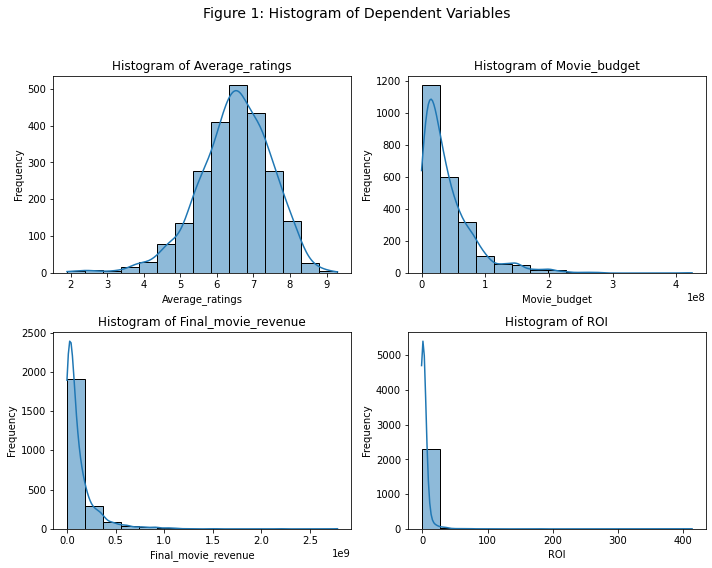

In [51]:
eda.plot_histograms(
    variables=["Average_ratings", "Movie_budget", "Final_movie_revenue", "ROI"],
    title="Figure 1: Histogram of Dependent Variables",
    bins=15,
    layout=(2, 2)
)

As we can see in Figure 1, the histogram for *Average_ratings* is bell-shaped, indicating a **normal distribution** of movie ratings.

As for the distribution of *Movie_budget*, *Final_movie_revenue* and *ROI* are highly skewed. In order to adresse that, we have to apply a log transformation to ROI which is a combination of the budget and revenue.

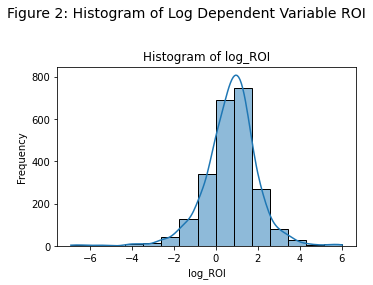

In [52]:
# Apply log transformation to skewed dependent variables
eda.dataframe = evaluation_utils.log_transform(eda.dataframe, ["ROI"])


eda.plot_histograms(
    variables=["log_ROI"],
    title="Figure 2: Histogram of Log Dependent Variable ROI",
    bins=15,
    layout=(1, 1)
)

Now we have successfully obtained a normal distribution for the *ROI*. 

Let's now look at our independent variables.

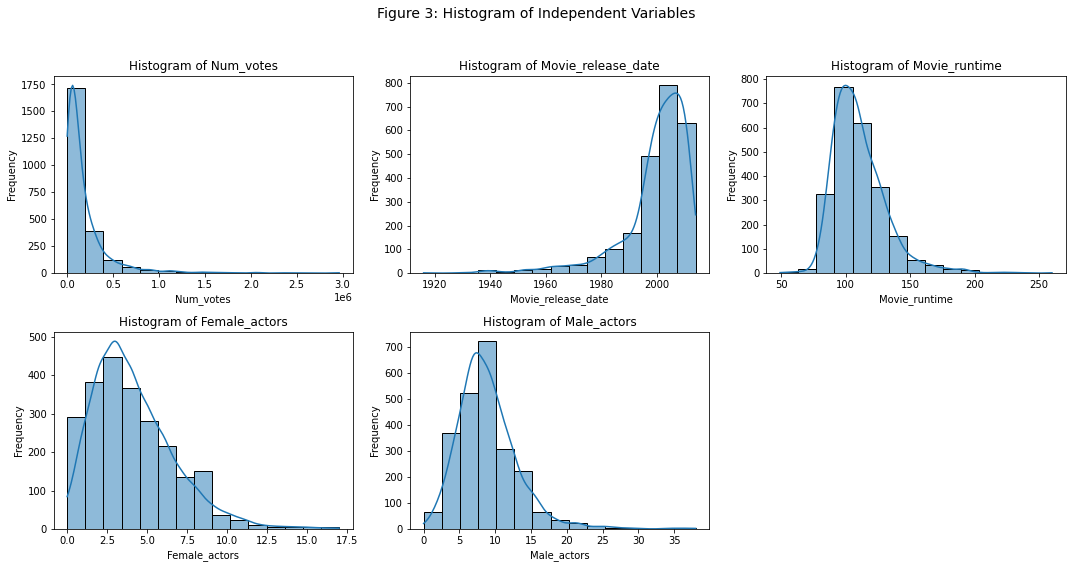

In [53]:
eda.plot_histograms(
    variables=["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"],
    title="Figure 3: Histogram of Independent Variables",
    bins=15,
    layout=(2, 3)
)

The histogram for the *Movie_release_date* shows an increase in movie releases after the 1980s, with a sharp spike around the 2000s. This suggests that the number of movie releases accelerated significantly in the late 20th and early 21st centuries.

Since the histogram for *Movie_release_date*, *Movie_runtime*, *Female_actors* and *Male_actors* are bell-shaped and follow a normal distribution, thus we keep these variables as they are.

For the *Num_votes*, we need to apply log transformation since it is skewed.

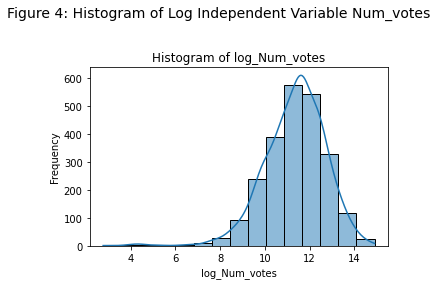

In [54]:
# Apply log transformation to skewed independent variables
eda.dataframe = evaluation_utils.log_transform(eda.dataframe, ["Num_votes"])

eda.plot_histograms(
    variables=["log_Num_votes"],
    title="Figure 4: Histogram of Log Independent Variable Num_votes",
    bins=15,
    layout=(1, 1)
)

Log of Num_votes: A normal distribution with most movies receiving moderate number of votes and a smaller group of popular movies getting significantly more votes 

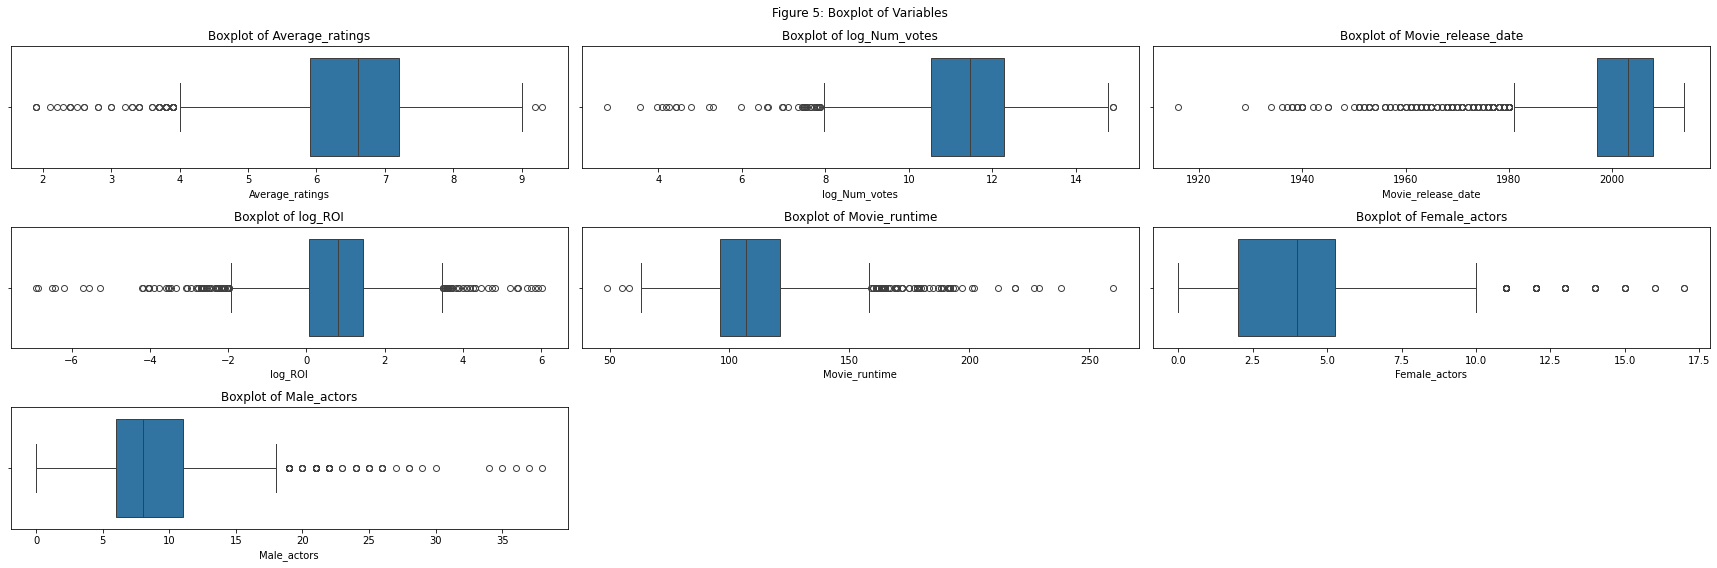

In [55]:
eda.numeric_columns = ["Average_ratings",
                   "log_Num_votes",
                   "Movie_release_date",
                   "log_ROI",
                   "Movie_runtime",
                   "Female_actors",
                   "Male_actors"]

eda.plot_boxplots()

We filter movies with a release date after 1970 and a runtime below 200 minutes to ensure meaningful results from our linear regression model. The movies post-1970 align more with modern filmmaking trends, audience preferences, and even available data quality, all contributing to minimizing potential biases based on older production trends. Limiting runtime to under 200 minutes helps exclude extreme outliers that could distort model coefficients, as excessively long films are rare and often follow unconventional storytelling formats, making them less representative of typical movie characteristics.

In [56]:
# Filtering movies after 1970 awith runtime less than 200 minutes
eda.dataframe = eda.dataframe[(eda.dataframe["Movie_release_date"] > 1970) & (eda.dataframe["Movie_runtime"] < 200)]

In [57]:
print(f"After filtering the dataframe we are left with {len(eda.dataframe):,} movies.")

After filtering the dataframe we are left with 2,268 movies.


We now have to focus on outliers and removing them for a more accurate modeling. From the boxplots, we chose the remove the outliers of the *Movie_box_office_revenue* and the *Minutes_runtime* variables. To do that, we use the **InterQuartile Range (IQR) method**, which identifies values that are significantly higher or lower than the majority of the data.

The *remove_outliers* function will calculate the IQR for each column specified and removes any rows with values outside the range:

$[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$


In [58]:
# eda.numeric_columns = ["Average_ratings",
#                    "log_Num_votes",
#                    "Movie_release_date",
#                    #"log_Final_movie_revenue",
#                    "log_ROI",
#                    "log_Movie_runtime",
#                    "log_Female_actors",
#                    "log_Male_actors",
#                    "Movie_success"]

# # Dataframe without outliers
# eda.dataframe = data_utils.remove_outliers(eda.dataframe, eda.numeric_columns)

# eda.plot_boxplots()

In [59]:
# print(f"After removing the outliers and dropping the null values, we are left with {len(eda.dataframe):,} movies.")

We now plot the average female percentage over time.

In [60]:
eda.plot_female_percentage(columns= ["Movie_release_date"], plot_type="Line")

This graph reveals the trajectory of female representation in films from 1980 to 2014. The data reveals fluctuations in the average percentage of female actors in the 80s, with a gradual upward trend from the 90s onwards. However, this graph only gives infomation as a proportion of female actors. 

Let us take a closer look at the distribution of the frequency of female actors vs male actors. We superpose the histograms of female and male actors frequency plotted earlier in order to compare them.

In [61]:
eda.frequency_actors_gender()

This barplot shows that both male and female frenquency count have a normal distribution. The peak frequency for female actors occurs at a much lower count of **3 against 8** for male actors. Futhermore, the distribution of female counts is slightly right skewed. This underscores a disparity in representation. Therefore, male actors appear to dominate ensemble casts, whilst female actors appear to be represented in smaller numbers.

##### 1.1.2 Bivariate Analysis of continuous variables

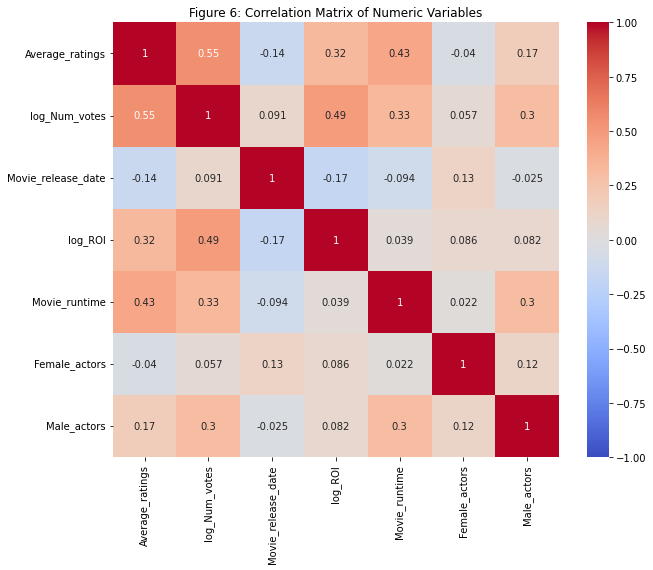

In [62]:
eda.plot_correlation_matrix()

The correlation matrix for the continuous variables in our dataset shows the following relationships:

•⁠  *⁠Female_actors* and *Male_actors*: The correlation coefficient is *0.12*, indicating a weak positive correlation. This suggests that movies with a higher number of female actors also tend to have a higher number of male actors. We note that this could indicate a general tendency for larger casts to include more actors of both genders.

•⁠  *log_Female_actors* and *Movie_release_date*: The correlation coefficient is *0.13*, indicating a weak positive correlation. This suggests that more recent movies tend to include a higher number of female actors. 

While gender composition affects the correlation, these findings highlight the need for deeper analysis (e.g., regression) to control for potential confounders and isolate the impact of gender on box office success.

#### 1.1.3 Analysis and encoding of categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

##### 1.1.3.1 Analysis of the Movies' genres

We set a cutoff threshold of 200. This means all genres with less than 200 occurences will be discarded. 

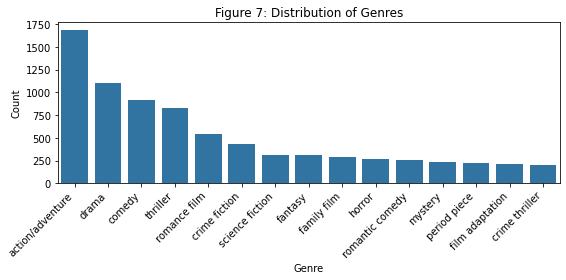

There are 15 genres with more that 200 occurences.


In [63]:
filtered_genre_counts = eda.filter_and_count(column_name="Movie_genres", threshold=200)

Let us check if this restricts our study to too few movies.

In [64]:
popular_genres = eda.analyze_popular_genres(filtered_genre_counts=filtered_genre_counts)

There are 2246 movies that belong to at least one of the 15 most popular genres. 
There were 2268 movies in the dataset before this operation, meaning we lost 0.97% of the movies.


We can drop the movies that have none of the most popular genres. We can also assume that the genres are ordered by relevance. This assumption was made after manually checking for 50 randomly sampled movies. It was true for all 50. We will thus keep for each movie, the first popular genre that appears.

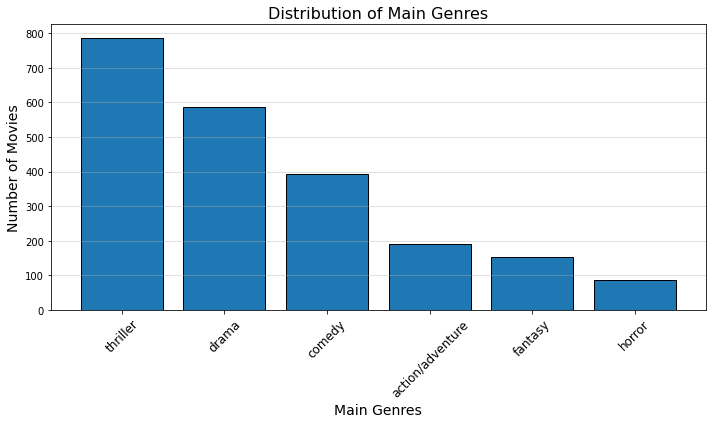

In [65]:
# Creating a new column named "Main_genre" that stores, for each movie, the first occurence of one of the popular genres
eda.get_main_genres(popular_genres=popular_genres)

We can now create the dummy variables for the "Main_genre" column using one-hot encoding.

In [66]:
eda.dataframe["Movie_main_genre"] = eda.dataframe["Main_genre"] # Backup the original genre column before get_dummies
eda.dataframe = pd.get_dummies(eda.dataframe, columns=["Main_genre"], drop_first=True)
eda.dataframe.sample(5)

,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,ROI,Normalized_Rating,log_ROI,log_Num_votes,Movie_main_genre,Main_genre_comedy,Main_genre_drama,Main_genre_fantasy,Main_genre_horror,Main_genre_thriller
617,tt1596343,7.30,413677,fast five,fast five,0,2011,nm0510912,"nm0604555,nm0860155","2,011.00",...,4.01,0.73,1.61,12.93,thriller,False,False,False,False,True
1899,tt0076257,6.40,20694,the kentucky fried movie,the kentucky fried movie,0,1977,nm0000484,"nm0001878,nm0000720,nm0958387","1,977.00",...,32.33,0.64,3.51,9.94,comedy,True,False,False,False,False
928,tt0251160,7.10,145978,john q,john q,0,2002,nm0001024,nm0444006,"2,002.00",...,0.97,0.71,0.68,11.89,thriller,False,False,False,False,True
93,tt1815862,4.80,211365,after earth,after earth,0,2013,nm0796117,"nm1729428,nm0796117,nm0000226","2,013.00",...,0.93,0.48,0.66,12.26,NaN,False,False,False,False,False
1348,tt0250687,6.50,125045,rat race,rat race,0,2001,nm0958387,nm0106563,"2,001.00",...,0.78,0.65,0.58,11.74,action/adventure,False,False,False,False,False


In [67]:
eda.plot_female_percentage(columns=["Movie_main_genre"], plot_type = "Bar")


This barplot reveals the distribution of average female actor percentages across various movie genres. **Action/adventure** movies show the lowest representation, with female actors averaging just over **20%**. In contrast, genres such as **comedy**, **drama**, and **horror** exhibit significantly higher percentages, nearing **35%**. These findings suggest that representation is lower in more physical genres such as **action/adventure** further underlining the narrative of male physical dominance. More emotional genres such as **drama** have a higher representation of women which is unsurprising considering societal norms that label women as more sensitive.

We can now look at the distribution of average female percentage throught the years for each most represented movie genres. 

In [68]:
eda.plot_female_percentage(columns=["Movie_release_date", "Movie_main_genre"], plot_type = "Interactif by genre")

When toggling between genres, distinct patterns emerge. In **drama**, the average female actor percentage is showing a consistent growth from the late 1980s, peaking in the early 2000s before a slight decline. **Comedy**, on the other hand, demonstrates more fluctuations but maintains relatively high representation throughout the years.

The doistribution for **fantasy** spikes in female representation during specific years, probaby indicating efforts to highlight strong female leads. In contrast, **thriller and horror** genres show inconsistency, though we notice a significant peak around the 2010s for **horror** movies.

The **action/adventure** genre remains the most male-dominated, with female representation rarely exceeding 30%.

We now decide to visualize gender comparison across metrics, here being ROI and Normalized Rating.

In [69]:
eda.plot_gender_comparison(columns=["log_ROI", "Normalized_Rating"])

From the Return On Investment (ROI) standpoint, a general upwards trend can be noticed for both male and female actors. The optimal number of actors differs significantly between genders. On one hand, an average number of 15 female actors produces a peak log(ROI) of 1.619, corresponding to an ROI of **5.04**. On the other hand, double that amount of male actors produces a peak log(ROI) of 2.173, corresponding to an ROI of **8.785**.

We now look at the relationship between our data when considering one genre at a time.

In [70]:
eda.plot_gender_comparison(columns=["log_ROI", "Normalized_Rating"], interactive=True)

- **Drama and Comedy**: The results resemble the one of the general analysis. For both of them, the sweet spot for ROI occurs with around 15 female actors, showing a peak log(ROI) of 1.702, corresponding to a ROI of approximately **5.48**. For **drama**, the peak for male cast appears much later with around 22 male actors for a log (ROI) of 2.146 corresponding to a ROI of **8.55**. For **comedy**, the highest peak is at 24 male actors for a log (ROI) of 1.984 corresponding to a ROI of **7.27**. For more emotional movie genres, female actors therefore can achieve notable ROIs, yet male-dominated casts still reach higher peaks, reflecting persistent gender disparities.

- **Horror, Thriller and Fantasy**: Similar patterns emerge, showing a consistent preference for male actors in achieving higher ROI.

- **Action/Adventure**: The action/adventure genre demonstrates a significant skew toward male actors. The highest log(ROI) of 2.288, equivalent to an ROI of **9.85**, is observed with 26 male actors. In comparison, the highest ROI for female actors is just over half of this value, highlighting the strong male dominance within this genre.


As for Normalized Ratings, for both the general analysis and the genre analysis, we can see the trends are globally constant indicating deeper analysis is necessary.

##### 1.1.3.2 Analysis of the Movies' languages

We will plot the top 5 languages by number of occurences:

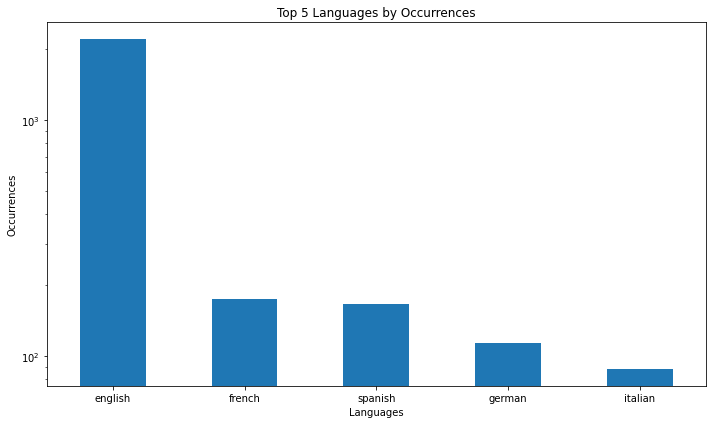

In [71]:
eda.analyze_languages()

We have an unbalanced dataset with English being much more prominent than other languages.

Categorizing movies into two groups: 
- those available exclusively in English, 
- those available in other languages (which may include English alongside another language).

This will be done through the creation of the boolean "Is_not_only_english" which is True when the movie is available in another language.

In [72]:
eda.categorize_languages()

There are 686 movies that are available in other languages and 1560 movies that are only available in English.


##### 1.1.3.2 Analysis of the Movies' countries

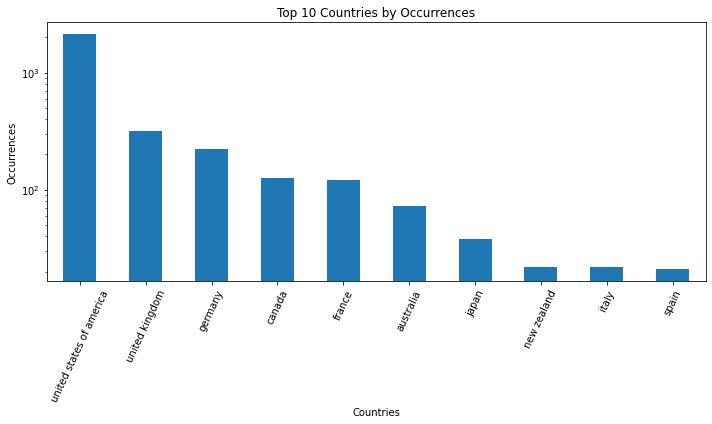

In [73]:
eda.analyze_countries()

We have a very similar situation to the languages. The United States of America have a much more prominent number of movies. We will thus proceed like previously by categorizing the movies into two groups:
- USA movies 
- Movies from other countries 

This will be done through the creation of the boolean "Is_USA_movie" which is True when the movie is from the USA.

In [74]:
count_usa_movies = (eda.dataframe["Movie_countries"] == "united states of america").sum()
count_other_countries_movie = len(eda.dataframe) - count_usa_movies 
print(f"There are {count_usa_movies} USA movies and {count_other_countries_movie} movies from other countries.")

There are 1476 USA movies and 763 movies from other countries.


In [75]:
eda.categorize_countries()

There are 1476 USA movies and 763 movies from other countries.


##### 1.1.3.2 Analysis of the Movies' production companies

There are 2368 unique production companies.


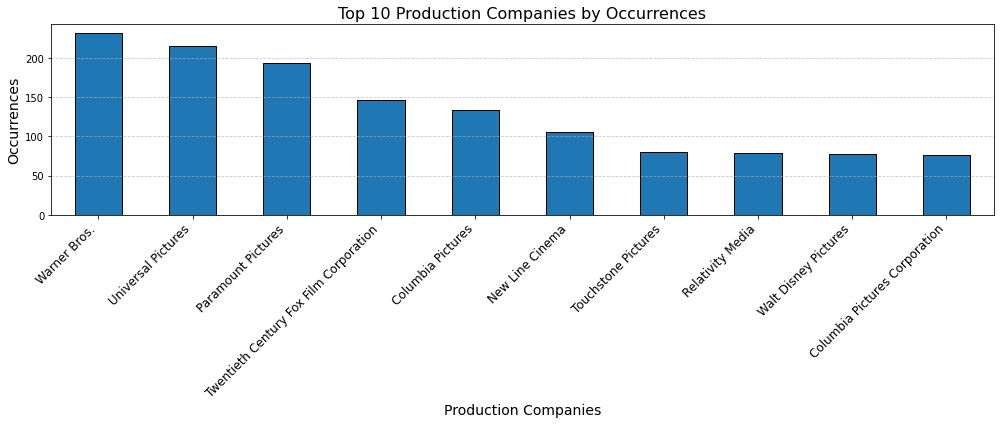

In [76]:
filtered_production_count = eda.analyze_production_companies()

In [77]:
prod_companies = pd.read_csv("data/Extra CSV/production_companies.csv")

box_office = eda.merge_production_data(filtered_production_count, prod_companies)


We inspect the company names and we saw that there are Columbia Pictures and Columbia Pictures Corporation. There are two names for the same company. 
We apply unify_columbia_revenue to attribute the same revenue for them. 

In [78]:
eda.unify_columbia_revenue(box_office_df=box_office)


In [79]:
box_office["Total Worldwide Box Office"] = box_office["Total Worldwide Box Office"].replace(
    {"\$": "", ",": ""}, regex=True).astype(float)

def calculate_box_office(companies_list):
   if not companies_list:
        return 0  
   return box_office.loc[box_office["Company Name"].isin(companies_list), "Total Worldwide Box Office"].sum()

eda.dataframe["Box_office_companies"] = eda.dataframe["Production_companies_cleaned"].apply(calculate_box_office)
eda.filter_movies_with_box_office(box_office_column="Box_office_companies")

After removing rows without Box Office revenue, 2221 movies remain out of 2221.


In [80]:
print(eda.dataframe.columns)


Index(['tconst', 'Average_ratings', 'Num_votes', 'Primary_title',
       'Original_title', 'Is_adult', 'Start_year', 'Directors', 'Writers',
       'Movie_release_date', 'Movie_languages', 'Movie_countries',
       'Movie_genres', 'Cast', 'Female_actors', 'Male_actors',
       'Female_actor_percentage', 'Movie_runtime', 'Plot Summaries',
       'Popularity', 'Production_companies', 'production_countries',
       'Movie_budget', 'Final_movie_revenue', 'ROI', 'Normalized_Rating',
       'log_ROI', 'log_Num_votes', 'Movie_main_genre', 'Main_genre_comedy',
       'Main_genre_drama', 'Main_genre_fantasy', 'Main_genre_horror',
       'Main_genre_thriller', 'Is_not_only_english', 'Is_USA_movie',
       'Production_companies_cleaned', 'Box_office_companies'],
      dtype='object')


#### 1.1.4 Analysis of ROI, ratings and movie success

In [81]:
eda.plot_average_log_roi_genres()

In [82]:
eda.plot_roi_trends_high_low_rated()

In [83]:
eda.plot_ratings_vs_roi_scatter()

In [84]:
eda.plot_revenue_ratings_trends_by_genre()

In [85]:
# Calculating the Movie Success metric after realizing that ROI and ratings do not represent movie success alone
eda.dataframe = evaluation_utils.calculate_weighted_success(eda.dataframe, 0.67)

In [86]:
eda.plot_movie_success_by_decade_genre_line()

### 1.2 Identifying Potential Confounders
In order to not have bias in our study, it is essential we add the confounders. This means that we have to identify the variables that have an impact on both treatment and outcome, here being the actor gender and the final box office revenue respectivly. The confounders are: 
-  ⁠Movie_genre
-  ⁠Movie_countries
- ⁠Movie_languages
- Num_votes

### 1.3 General Linear Regression

In [87]:
final_df_regression = eda.dataframe.copy()

# Calculating the Movie Success metric
final_df_regression = evaluation_utils.calculate_weighted_success(final_df_regression, 0.67)

We will run a different regression for each of the following dependent variables:
- $ln(\text{ROI})$
- Normalized Ratings
- Movie Success metric

Let's start with $ln(\text{ROI})$:

In [88]:
# Define independent and dependent variables
indep_vars = ["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie",  "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_fantasy", "Main_genre_horror", "Movie_release_date",
                   "Box_office_companies", "log_Num_votes"]

dep_var = "log_ROI"

# Run the regression along with necessary preprocessing and metrics
regression.run_regression(final_df_regression, indep_vars, dep_var)

NameError: name 'pd' is not defined

Let us analyze the results from the regression on `log_ROI`:
- **$F$-statistic**: The p-value of the F-statistic is almost equal to zero. This means we can reject the null hypothesis that all coefficients are equal to zero at the 5% significance level, leading us to conclude that the model is statistically significant at the 5% significance level.

- **$R^2$ and Adjusted $R^2$**: The $R^2$ value indicates a moderate fit, however a significant portion of the variance (around 65%) is not explained, suggesting factors not included in the model might influence `log_ROI`. The Adjusted $R^2$ being close to the $R^2$ suggests the model is not overfitting.

- **Durbin-Watson statistic**: The Durbin-Watson statistic is close to 2 suggesting there is no autocorrelation of the residuals in the model.

- **RMSE**: The Root mean squared error is of 0.96, indicating a relative error of 7.46% on the test set.

- **Insignificant predictors**: `Is_not_only_english`, `Main_genre_thriller`, `Main_genre_fantasy` and `Production_companies` are all statistically insignificant at the 5% significance level.

- **Notable coefficients**: It can be noted amongst the statistically significant predictors that the number of female actors has a positive coefficient as opposed to the number of male actors having a negative one. This suggests that movies with more women perform better in terms of return on investment. Is this increase in performance due to the right reasons? We will dive deeper into that in Part 5 of our analysis.

Let's now regress on the Normalized Ratings and the Movie Success metric:

In [ ]:
# Removing log_Num_votes as it is involved in the calculation of Normalized_Rating and Movie_success
indep_vars.remove("log_Num_votes")

# Define new dependent variables
dep_vars = ["Normalized_Rating", "Movie_success"]

show_VIF = True
for dep_var in dep_vars:
    # Run the regression along with necessary preprocessing and metrics
    regression.run_regression(final_df_regression, indep_vars, dep_var, show_VIF)
    
    # Only display VIF information once as the independent variables have not changed
    show_VIF = False

Let us analyze the regression on `Normalized_Rating` first:
- **$F$-statistic**: The p-value of the F-statistic is nearly zero. This allows us to reject the null hypothesis that all coefficients are equal to zero at the 5% significance level we can conclude that the model is statistically significant.

- **$R^2$ and Adjusted $R^2$**: The \( R^2 \) value indicates that approximately 24.9% of the variance in `Normalized_Rating` is explained by the predictors. The adjusted \( R^2 \) being close to \( R^2 \) suggests that the model is not overfitting.

- **Durbin-Watson statistic**: The Durbin-Watson statistic is close to 2, indicating no significant autocorrelation in the residuals.

- **RMSE**: The Root Mean Squared Error is 0.08, with a relative error of 11.25% on the test set. This suggests the model does not make big errors on the test dataset

- **Insignificant predictors**: `Is_USA_movie` and `Main_genre_horror` are statistically insignificant at the 5% significance level.

- **Notable coefficients**:
  - The number of female actors has a negative coefficient and is statistically significant, suggesting that an increase in female actors slightly decreases the normalized rating whilst the number of male actors has a positive coefficient and is significant, suggesting an increase in male actors is associated with a higher normalized rating. These results are opposite to what was seen with `log_ROI`


Let us analyze the regression on `Movie_Success` next:
- **$F$-statistic**: The p-value of the F-statistic is nearly zero. This allows us to reject the null hypothesis that all coefficients are equal to zero at the 5% significance level, we can conclude that the model is statistically significant.

- **$R^2$ and Adjusted $R^2$**: The \( R^2 \)suggests that only 10.2% of the variance is explained by the predictors. The low \( R^2 \) indicates that a significant portion of the variance remains unexplained, suggesting that additional factors may contribute to `Movie_Success`. The adjusted \( R^2 \) being close to \( R^2 \) suggests no overfitting.

- **Durbin-Watson statistic**: The Durbin-Watson statistic is close to 2, indicating no significant autocorrelation in the residuals.

- **RMSE**: The RMSE is 0.11, with a relative error of 10.64% on the test set. This suggests a reasonable level of accuracy in predicting `Movie_Success`.

- **Insignificant predictors**: `Female_actors`, `Is_USA_movie`, `Main_genre_thriller`, and `Box_office_companies` are statistically insignificant at the 5% significance level.

An important factor to note is that genres' significance varies from one regression to the next. Indeed, the expectations gender wise of movies varies largely from one genre to the next. It is thus important to take a deeper look into the different genres. We will analyze these differences thanks to genre specific linear regressions.

### 1.4 Genre specific Linear Regression

In this section, we will run regressions of subsets of our dataset corresponding to each main genre we have identified. This will produce many different regressions. The same rigourous analysis was conducted on each regression results. However, to avoid cluttering the notebook, we will not go into as much detail and only report notable results.

In [ ]:
# Setting up the genre columns
genre_columns = ["Main_genre_drama", "Main_genre_thriller", "Main_genre_comedy", 
                "Main_genre_fantasy", "Main_genre_horror"]

# Define variables for regression on individual genres
indep_vars = ["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Movie_release_date","Box_office_companies", "log_Num_votes"]

# Setting up the dependent variable
dep_var = "log_ROI"

show_VIF = True
for genre in genre_columns:
    # Run the genre specific regression along with necessary preprocessing and metrics
    regression.run_regression(final_df_regression, indep_vars, dep_var, show_VIF, genre)
    
    # Only display VIF information once as the independent variables have not changed
    show_VIF = False

- **Drama**: 
  - **Male_actors**: Negative coefficient and not significant at the 5% level, \(p = 0.079\). Suggests that having more male actors is associated with a slight decrease in `log_ROI`, though this is not strongly significant.
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.375\). Gender composition of the cast does not appear to significantly influence ROI for drama films.
  - **Movie_runtime**: Significant negative impact, \(p < 0.001\), indicating longer dramas are associated with lower ROI.

- **Thriller**: 
  - **Female_actors**: Positive and significant coefficient, \(p = 0.010\). An increase in female actors is associated with a higher ROI for thrillers, suggesting that female representation may positively impact returns in this genre.
  - **Male_actors**: not significant at the 5% level, \(p = 0.541\). Male actor representation has no noticeable impact on ROI for thrillers.
  - **Movie_runtime**: Significant negative impact, \(p < 0.001\). Longer thrillers tend to have lower ROI.

- **Comedy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.320\). Female representation does not significantly influence ROI in comedies.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.313\). Male representation also has no significant impact on ROI for comedies.
  - **Movie_release_date**: Significant negative impact, \(p < 0.001\). Older comedy movies tend to have higher ROI.

- **Fantasy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.055\). Having more female actors does not significantly increase ROI for fantasy movies.
  - **Male_actors**: not significant at the 5% level, \(p = 0.547\). Male representation has no noticeable impact on ROI for fantasy movies.
  - **Movie_runtime**: Significant negative impact, \(p = 0.016\). Longer fantasy movies are associated with lower ROI.

- **Horror**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.574\). Female representation has no significant impact on ROI for horror movies.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.227\). Male representation shows no significant impact on ROI.
  - **log_Num_votes**: Positive and significant coefficient, \(p = 0.046\). Popularity (as measured by votes) is a stronger driver of ROI for horror movies than gender representation.
  - **Model Significance**: Overall \(R^2 = 0.172\) and an insignificant F-statistic, \(p = 0.158\), suggest that this model does not explain much of the variance in ROI for horror movies.

- **General Observations**: 
  1. The impact of **female actors** is most pronounced in the **thriller genre**, where it significantly increases ROI, \(p = 0.010\).
  2. **Male actors** consistently show negative or insignificant effects on ROI across all genres.
  3. The **runtime** of movies has a strong negative impact on ROI across most genres (e.g., Drama, Thriller, Fantasy).
  4. The **Fantasy genre** shows that female actors do not significantly influence ROI, \(p = 0.055\).
  5. The **Horror genre** model appears poorly fitted overall, with insignificant predictors and low explanatory power. Gender effects are negligible here.

In [ ]:
# Removing log_Num_votes as it is involved in the calculation of Movie_success
indep_vars.remove("log_Num_votes")

# Setting up the dependent variable
dep_var = "Movie_success"

show_VIF = True
for genre in genre_columns:
    # Run the genre specific regression along with necessary preprocessing and metrics
    regression.run_regression(final_df_regression, indep_vars, dep_var, show_VIF, genre)
    
    # Only display VIF information once as the independent variables have not changed
    show_VIF = False

- **Drama**: 
  - **Female_actors**: Negative but not significant at the 5% level, \(p = 0.342\). Female representation does not significantly influence movie success in drama films.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.731\). Male representation also shows no significant impact on movie success.
  - **Movie_runtime**: Positive and significant, \(p = 0.034\). Longer runtime is associated with higher success for drama films.
  - **Is_not_only_english**: Positive and significant, \(p = 0.002\). Non-English drama movies tend to have higher success.
  - **Movie_release_date**: Negative and significant, \(p < 0.001\). Older drama movies tend to have higher success.

- **Thriller**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.064\). Female representation does not significantly influence movie success in thrillers.
  - **Male_actors**: not significant at the 5% level, \(p = 0.764\). Male representation has no noticeable impact on movie success for thrillers.
  - **Movie_runtime**: Positive and significant, \(p < 0.001\). Longer runtime is associated with higher success for thrillers.
  - **Movie_release_date**: Negative and significant, \(p < 0.001\). Older thriller movies tend to have higher success.

- **Comedy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.445\). Female representation does not significantly influence movie success in comedies.
  - **Male_actors**: Positive and significant, \(p = 0.011\). An increase in male actors is associated with higher success in comedy films.
  - **Movie_runtime**: Positive and significant, \(p = 0.001\). Longer runtime is associated with higher success for comedies.
  - **Is_not_only_english**: Positive and significant, \(p = 0.014\). Non-English comedy movies tend to have higher success.
  - **Movie_release_date**: Negative and significant, \(p = 0.006\). Older comedy movies tend to have higher success.

- **Fantasy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.813\). Female representation does not significantly influence movie success in fantasy films.
  - **Male_actors**: Positive and significant, \(p = 0.020\). An increase in male actors is associated with higher success in fantasy movies.
  - **Movie_runtime**: not significant at the 5% level, \(p = 0.476\). Runtime has no noticeable impact on success for fantasy movies.
  - **Box_office_companies**: Negative but not significant at the 5% level, \(p = 0.072\). A higher number of box office companies may slightly reduce success, but the result is not strongly significant.

- **Horror**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.796\). Female representation has no significant impact on movie success in horror films.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.625\). Male representation shows no significant impact on movie success.
  - **Movie_runtime**: Negative but not significant at the 5% level, \(p = 0.190\). Runtime does not significantly influence success for horror films.
  - **Model Significance**: Overall \(R^2 = 0.062\) and an insignificant F-statistic, \(p = 0.772\), suggest that this model does not explain much of the variance in movie success for horror films.

- **General Observations**: 
  1. The impact of **female actors** is not significant at the 5% level across all genres.
  2. **Male actors** have a significant positive impact on success in **comedy** and **fantasy** genres, but no noticeable impact in other genres.
  3. **Movie_runtime** positively influences movie success in **drama**, **thriller**, and **comedy** genres, while having no significant impact in **fantasy** and **horror**.
  4. **Movie_release_date** is consistently negative and significant for **drama**, **thriller**, and **comedy**, suggesting older movies perform better in these genres.
  5. The **horror genre** model has low explanatory power, with no significant predictors and a high relative error.

### 4. How does it compare to streaming platforms?

In this section, we want to expand our study by analyzing data from various streaming platforms. We focus on the movies of Netflix, Amazon Prime, Disney+, and Hulu. To achieve this, we created a dataset by merging data from multiple sources found on Kaggle.


This dataset structure enables comprehensive analysis across various dimensions such as gender repartition in the cast, the ratings and description. Using these columns, we can investigate how streaming platform movies differ in content and ratings compared to traditional box office movies.

Actor genders were assigned using multiple CSV files and using a website called **Genderize.io** which provides gender predictions based on names.

Given the large number of genres in the dataset, we grouped them into broader categories to simplify our analysis.

In [ ]:
streaming_df = get_streaming_dataframe()

In [ ]:
streaming_df.head()

In [ ]:
streaming_df.drop_duplicates(inplace=True)


To measure the success of a movie we decided to use **ratings** as our main metric. Ratings are a clear way to show how much audiences enjoy a film, making them a reliable measure of success. Streaming platforms often use ratings from users to recommend content which shows how important they are for understanding audience preferences and movie success.

By using ratings, we can explore how things like gender diversity, genre, and other factors affect a movie’s success. The best way we chose to conduct this analysis is through a **Regression Analysis**.

Before diving into regression, we should perform an **Exploratory Data Analysis (EDA)** to understand the relationships among variables and detect any anomalies.

#### 4.1 Exploratory Data Analysis for Streaming (EDA)

As in our previous analysis of box office movies, we will start by identifying the key variables of interest to guide our study. 

Categorical variable:
- *Actor_gender*: An actor is either Male or Female. 
- *isAdult*: A boolean. Returns 1 if it a +18 rated movie
- *Movie_genre*
- *Movie_countries*, 
- *Movie_languages*
- *Platform*

Continous variable:

- *Average_ratings* and :  the dependent variable of our studies.    



##### 4.1.1 Univariate Analysis of continuous variables


In [ ]:
eda_streaming = EDA(streaming_df.copy())


In [ ]:
eda_streaming.plot_comparison_percentage_female(
    second_dataframe=eda.dataframe, 
    year_column_primary="Movie_release_date", 
    year_column_secondary="Start_year", 
    title="Comparison of Average Percentage of Female Actors per Movie (After 1970)"
)


- Both streaming platforms and box office movies show a steady rise in the percentage of female actors over time. This indicates a positive societal shift toward including more diverse perspectives in storytelling.


- Streaming platforms consistently feature a higher percentage of female representation compared to box office movies. This trend may be due to the flexibility that streaming platforms enjoy.


- After 2015, the percentage of female actors rises significantly, coinciding with the expansion of streaming platforms like Netflix and their focus on original content. This suggests that streaming platforms are playing a key role in driving more inclusive practices.



As a numerical analysis, we can show a table with the minimum, maximum, mean, standard deviation (SD) and median of each variable.

In [ ]:
pd.options.display.float_format = "{:,.2f}".format

# Filtrer uniquement les colonnes qui existent dans la dataframe
existing_numeric_columns = [col for col in eda_streaming.numeric_columns if col in eda_streaming.dataframe.columns]

# Convert columns to numeric for existing columns and drop rows with missing data
eda_streaming.dataframe[existing_numeric_columns] = eda_streaming.dataframe[existing_numeric_columns].apply(pd.to_numeric, errors="coerce")
eda_streaming.dataframe.dropna(subset=existing_numeric_columns, inplace=True)

# Summary statistics
summary_table = eda_streaming.summary_bis()

summary_table


In [ ]:
eda_streaming.plot_histograms(
    variables=["Average_ratings"],
    title="Histogram of Average Ratings",
    bins=15,
    layout=(1, 1)
)

The histogram shows a nearly **normal distribution** of *Average_ratings*, with most movies receiving ratings between 6 and 7.

Let's look at our independent variables

In [ ]:
variables = ["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"]

eda_streaming.plotly_kde(
    variables=variables,
    bins=15,
    second_dataframe=eda.dataframe,
    save_html=False,
    output_dir="./histograms_plots"
)


- The KDE curve of *Movie_release_date* aligns with the growth of streaming platforms around 2015. During this time, platforms like Netflix began producing their own content and expanding their services globally. The small decrease in the curve after 2020 is likely due to the lack of recent data in the dataset. The spike in film releases reflects the rise of the streaming era and shows how society is adapting to new entertainment trends.


- The distribution of *Male_actors* and *Female_actors* reveals distinct patterns. Streaming platforms tend to have a more balanced representation of men and women. This inclusivity contrasts with box office movies, which are still influenced by genres traditionally dominated by male casts.


- The *Movie_runtime* graph shows that streaming platforms often favor shorter films, appealing to audiences who prefer binge-watching. This trend contrasts with box office movies, which tend to have longer runtimes, likely to meet the expectations of the theatrical experience.


In [ ]:
# Apply log transformation to skewed independent variables
eda_streaming.dataframe = evaluation_utils.log_transform(eda_streaming.dataframe, ["Num_votes"])

eda_streaming.plot_histograms(
    variables=["log_Num_votes"],
    title="Histogram of Log Independent Variable Num_votes",
    bins=15,
    layout=(1, 1)
)


Log_Num_Votes : The distribution is approximately normal with most movies receiving a moderate number of votes. Most movies have log-votes between 6 and 10.


In [ ]:
eda_streaming.numeric_columns = ["Average_ratings",
                   "log_Num_votes",
                   "Movie_release_date",
                   "Movie_runtime",
                   "Female_actors",
                   "Male_actors"]

eda_streaming.plot_boxplots()

The boxplots show us the distributions of key variables and highlight the presence of several outliers. We now have to focus on outliers and removing them for a more accurate modeling.

In [ ]:
eda_streaming.dataframe = data_utils.remove_outliers(eda_streaming.dataframe, eda_streaming.numeric_columns)

eda_streaming.plot_boxplots()

In [ ]:
print(f"After removing the outliers and dropping the null values, we are left with {len(eda_streaming.dataframe):,} movies.")

##### 4.1.2 Bivariate Analysis of continuous variables

In [ ]:
eda_streaming.plot_correlation_matrix()

The number of votes and gender composition (especially the number of male actors) seem to influence movie duration. It suggests that popularity and cast composition could impact movie production characteristics.
Weak correlations between movie duration and other variables indicate that duration might not strongly determine popularity based on votes.
This correlation matrix suggests further analysis like regression that could help separate and clarify the effects of gender and duration on popularity.

#### 4.1.3 Analysis and encoding of categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

##### 4.1.3.1 Analysis of the Movies' genres

We manually grouped the genres into broader categories because there were too many different genres in the dataset. This step was necessary to make the analysis more manageable and easier to interpret.

Let's analyze the two following graph :

In [ ]:
eda_streaming.analyze_female_actors_by_genre()

In [ ]:
eda_streaming.plot_female_percentage_evolution()

- Female representation remains consistent across all genres, reflecting an industry-wide shift toward inclusivity.

- The presence of female actors in genres such as Drama, Science Fiction, and Comedy showcases progress in creating more diverse stories that resonate with audiences.
- This balance demonstrates a collective effort by the film industry to reflect societal changes and meet audience expectations for gender diversity.

We set a cutoff threshold of 500. This means all genres with less than 500 occurences will be discarded. 

In [ ]:
filtered_genre_counts = eda_streaming.filter_and_count(column_name="Movie_genres", threshold=500)

Let us check if this restricts our study to too few movies.

In [ ]:
popular_genres = eda_streaming.analyze_popular_genres(filtered_genre_counts=filtered_genre_counts)

We can drop the Uncategorized genres to simplify our study

We choose to only keep only the movies xhich have at more 2 genres and create dummies with all other combinations.

In [ ]:
eda_streaming.dataframe = eda_streaming.dataframe[eda_streaming.dataframe["Movie_genres"].apply(lambda x: len(x.split(",")) <= 2)]

In [ ]:
eda_streaming.dataframe["Movie_genres"].value_counts()

We can now create the dummy variables for the "Main_genre" column.

In [ ]:

dummies = pd.get_dummies(eda_streaming.dataframe["Movie_genres"], prefix="Movie_genres", drop_first=True)

dummy_columns = dummies.columns.tolist()
print("Dummies columns :", dummy_columns)


In [ ]:
#eda_streaming.dataframe = pd.get_dummies(eda_streaming.dataframe, columns=["Movie_genres"], drop_first=True) 
eda_streaming.dataframe = pd.concat([eda_streaming.dataframe, dummies], axis=1)

eda_streaming.dataframe.sample(5)

##### 4.1.3.2 Analysis of the Movies' languages

We will plot the top 5 languages by number of occurences:

In [ ]:
eda_streaming.analyze_languages()

Categorizing movies into two groups: 
- those available exclusively in English, 
- those available in other languages (which may include English alongside another language).

This will be done through the creation of the boolean "Is_not_only_english" which is True when the movie is available in another language.

In [ ]:
eda_streaming.categorize_languages()

We have more movies that are available in other languages than in the previous dataset. This shows how streaming platforms are making efforts to cater to different communities and reach a wider, more diverse audience by offering content in various languages.

##### 4.1.3.2 Analysis of the Movies' countries

In [ ]:
eda_streaming.plot_average_rating_by_country(country_column="Movie_countries", rating_column="Average_ratings", color_scale="Purples")

We can see on this map that countries with darker shades show higher average ratings, showcasing regions where films are more successfull. The average ratings across countries should not be interpreted at face value due to unbalanced distribution of movies across regions. United States and India dominate the dataset with far more films than others, which could skew interpretations of their average ratings.

In [ ]:
eda_streaming.analyze_countries_plotly()

We have a very similar situation to the languages. The United States of America have a much more prominent number of movies. We will thus proceed like previously by categorizing the movies into two groups:
- USA movies 
- Movies from other countries 

This will be done through the creation of the boolean "Is_USA_movie" which is True when the movie is from the USA.

In [ ]:
eda_streaming.categorize_countries_bis()


We have more movies from other countries than in the previous dataset. Similar to languages, this shows how streaming platforms are making efforts to include diverse cultures and reach audiences from different parts of the world.

##### 4.1.3.2 Analysis of the Movies' streaming platforms 

We created dummy variables for the streaming platforms(Netflix, Disney, Amazon prime). Each platform is now a column with 0 or 1, where 1 means the movie is available on that platform.

In [ ]:
eda_streaming.dataframe = pd.get_dummies(eda_streaming.dataframe, columns=["Platform"], drop_first=True) 
eda_streaming.dataframe.sample(5)

### 4.2 Identifying Potential Confounders for Streaming
In order to not have bias in our study, it is essential we add the confounders. This means that we have to identify the variables that have an impact on both treatment and outcome, here being the actor gender and the final box office revenue respectivly. The confounders are: 
-  ⁠Movie_genre
-  ⁠Movie_countries
- ⁠Movie_languages
- Num_votes

### 1.3 Linear Regression

In [ ]:
streaming_df_regression = eda_streaming.dataframe.copy()

In [ ]:
indep_vars1=["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", "Is_USA_movie",
          'Platform_Disney', 'Platform_Netflix', "Is_Adult"]


indep_vars=np.hstack([indep_vars1, dummy_columns]) #dummy columns contains the column genre
dep_var = "Average_ratings"

regression.run_regression(streaming_df_regression, indep_vars, dep_var)

Let us analyze the regression on `Average_ratings`:

- **$F$-statistic**: The p-value of the F-statistic is nearly zero. This allows us to reject the null hypothesis that all coefficients are equal to zero at the 5% significance level, meaning the model is statistically significant.

- **$R^2$ and Adjusted $R^2$**: The \( R^2 \) value indicates that about 10% of the variance in `Average_ratings` is explained by the predictors. The adjusted \( R^2 \) is close to \( R^2 \), which shows the model is not overfitting but suggests there’s room for improvement.

- **RMSE**: The Root Mean Squared Error is 1.06, with a relative error of 17.90% on the test dataset. This indicates moderate predictive accuracy but also shows that the model may struggle with some predictions.

- **Insignificant predictors**: `Is_not_only_english` is statistically insignificant at the 5% significance level, meaning that having non-English content does not significantly impact the ratings.

- **Notable coefficients**:
  - **Female_actors** has a negative coefficient (-0.1248) and is statistically significant, indicating that movies with more female actors tend to have slightly lower ratings.
  - **Male_actors** also has a negative coefficient (-0.0550) and is statistically significant, though its impact is smaller compared to female actors.
  - **Movie_runtime** has a positive coefficient (0.2588) and is statistically significant, suggesting that longer movies tend to have higher ratings.
  - **Is_USA_movie** has a positive and significant coefficient (0.1538), showing that movies produced in the U.S. generally perform better in terms of ratings.
  - **Platform_Disney** and **Platform_Netflix** both have positive coefficients (0.1346 and 0.0899, respectively) and are significant, meaning that movies on these platforms tend to receive higher ratings.
  - **Genres**:
    - **Drama** and **Comedy** have positive and significant coefficients, indicating that these genres are generally associated with higher ratings.
    - **Thriller** and **Fantasy** also have significant positive effects, though smaller compared to Drama and Comedy.
    - **Horror** is not significant, suggesting that this genre does not strongly influence ratings.


### 4.4 Genre specific Linear Regression

In [ ]:
# Define variables for regression on individual genres
indep_vars1=["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", "Is_USA_movie",
          'Platform_Disney', 'Platform_Netflix', "Is_Adult", "log_Num_votes"]

#dummy columns contains the column genre

# Setting up the dependent variable
dep_var = "Average_ratings"

show_VIF = True
for genre in dummy_columns:
    # Run the genre specific regression along with necessary preprocessing and metrics
    regression.run_regression(streaming_df_regression, indep_vars, dep_var, show_VIF, genre)
    
    # Only display VIF information once as the independent variables have not changed
    show_VIF = False

### Action & Adventure, Drama & Emotion
- **Female_actors**: Negative but not significant at the 5% level, \(p = 0.345\). Female representation does not significantly influence average ratings in this genre.  
- **Male_actors**: Positive but not significant at the 5% level, \(p = 0.248\). Male representation shows no significant impact on average ratings.  
- **Movie_runtime**: Positive and significant, \(p < 0.001\). Longer runtime is associated with higher average ratings for movies in this genre.  
- **Is_not_only_english**: Positive and significant, \(p = 0.035\). Movies not exclusively in English tend to have higher ratings in this genre.  
- **Is_USA_movie**: Positive but not significant at the 5% level, \(p = 0.202\). Being a USA production does not significantly affect ratings.  
- **Platform_Disney**: Positive but not significant at the 5% level, \(p = 0.086\). Disney platform presence shows a slight trend towards higher ratings, but the result is not robust.  
- **Platform_Netflix**: Positive but not significant at the 5% level, \(p = 0.507\). Netflix platform presence does not significantly influence ratings.  
- **Is_Adult**: Positive and significant, \(p = 0.024\). Movies marked as adult content tend to have higher ratings in this genre.  

---

### Action & Adventure, Science Fiction & Fantasy
- **Female_actors**: Negative but not significant at the 5% level, \(p = 0.593\). Female representation does not significantly influence ratings in this genre.  
- **Male_actors**: Negative but not significant at the 5% level, \(p = 0.566\). Male representation does not significantly affect ratings.  
- **Movie_runtime**: Positive and significant, \(p = 0.002\). Longer runtime is associated with higher ratings in this genre.  
- **Is_not_only_english**: Negative but not significant at the 5% level, \(p = 0.613\). Non-English language status does not significantly impact ratings.  
- **Is_USA_movie**: Positive but not significant at the 5% level, \(p = 0.294\). Being a USA production shows no significant effect on ratings.  
- **Is_Adult**: Positive but not significant at the 5% level, \(p = 0.804\). Adult-marked movies do not show a significant effect on ratings.  

---

### Comedy & Light-Hearted
- **Female_actors**: Negative and significant, \(p < 0.001\). An increase in female actors is associated with lower average ratings in this genre.  
- **Male_actors**: Negative and significant, \(p = 0.002\). An increase in male actors is also associated with lower ratings.  
- **Movie_runtime**: Positive and significant, \(p = 0.008\). Longer runtime is linked to higher ratings.  
- **Is_not_only_english**: Negative and significant, \(p = 0.045\). Non-English movies tend to have lower ratings in this genre.  
- **Is_USA_movie**: Positive and significant, \(p = 0.010\). Being a USA production is associated with higher ratings.  
- **Platform_Disney**: Negative but not significant at the 5% level, \(p = 0.080\). Disney platform presence shows a slight negative trend in ratings, but the result is not robust.  
- **Platform_Netflix**: Negative but not significant at the 5% level, \(p = 0.337\). Netflix platform presence does not significantly impact ratings.  
- **Is_Adult**: Positive but not significant at the 5% level, \(p = 0.969\). Movies marked as adult content show no significant effect on ratings.  

---

### Drama & Emotion
- **Female_actors**: Negative but not significant at the 5% level, \(p = 0.157\). Female representation does not significantly impact ratings in this genre.  
- **Male_actors**: Positive but not significant at the 5% level, \(p = 0.328\). Male representation does not show a significant effect on ratings.  
- **Movie_runtime**: Positive and significant, \(p < 0.001\). Longer runtime is strongly associated with higher ratings.  
- **Is_not_only_english**: Positive and significant, \(p = 0.004\). Movies not exclusively in English tend to have higher ratings.  
- **Is_USA_movie**: Positive and significant, \(p = 0.003\). Being a USA production is linked to higher ratings.  
- **Platform_Disney**: Positive and significant, \(p = 0.003\). Disney platform presence is associated with higher ratings.  
- **Platform_Netflix**: Positive but not significant at the 5% level, \(p = 0.207\). Netflix platform presence shows no strong effect on ratings.  
- **Is_Adult**: Positive but not significant at the 5% level, \(p = 0.228\). Movies marked as adult content do not significantly impact ratings.  

---

### Science Fiction & Fantasy
- **Female_actors**: Negative but not significant at the 5% level, \(p = 0.443\). Female representation does not significantly impact ratings in this genre.  
- **Male_actors**: Negative but not significant at the 5% level, \(p = 0.304\). Male representation does not show a significant effect on ratings.  
- **Movie_runtime**: Positive and significant, \(p < 0.001\). Longer runtime is strongly associated with higher ratings.  
- **Is_not_only_english**: Negative but not significant at the 5% level, \(p = 0.448\). Non-English language status does not significantly influence ratings.  
- **Is_USA_movie**: Positive and significant, \(p = 0.033\). Being a USA production is associated with higher ratings.  
- **Platform_Disney**: Positive but not significant at the 5% level, \(p = 0.094\). Disney platform presence shows a slight positive trend, but the result is not robust.  
- **Platform_Netflix**: Positive but not significant at the 5% level, \(p = 0.165\). Netflix platform presence does not significantly affect ratings.  
- **Is_Adult**: Negative but not significant at the 5% level, \(p = 0.106\). Adult-marked movies do not significantly impact ratings.  

---

### Science Fiction & Fantasy, Drama & Emotion
- **Female_actors**: Positive but not significant at the 5% level, \(p = 0.804\). Female representation does not significantly influence ratings in this genre.  
- **Male_actors**: Positive but not significant at the 5% level, \(p = 0.301\). Male representation does not show a significant effect on ratings.  
- **Movie_runtime**: Positive and significant, \(p = 0.004\). Longer runtime is associated with higher ratings.  
- **Is_not_only_english**: Positive but not significant at the 5% level, \(p = 0.108\). Non-English movies may have slightly higher ratings, but this is not robust.  
- **Is_USA_movie**: Negative but not significant at the 5% level, \(p = 0.832\). Being a USA production does not significantly impact ratings.  
- **Platform_Disney**: Negative but not significant at the 5% level, \(p = 0.902\). Disney platform presence does not significantly affect ratings.  
- **Platform_Netflix**: Negative but not significant at the 5% level, \(p = 0.589\). Netflix platform presence does not significantly influence ratings.  
- **Is_Adult**: Negative but not significant at the 5% level, \(p = 0.850\). Adult-marked movies show no discernible effect on ratings.  


### 5. <u>What are the social reasons behind the presence of female characters in movies? Is it due to sexualization or genuine equality of representation?</u>

First, we will look at existing datasets that could give us a better general idea on the representation of women in movies.

#### 5.1 <u>Bechdel Dataset</u>

The first dataset is the Bechdel dataset. The Bechdel dataset evaluates movies based on the Bechdel Test, which checks if a film has (1) at least two named women who (2) talk to each other (3) about something other than a man. It includes the Bechdel scores, which range from 0 to 3, each point reflecting one of the previously mentioned criteria. This dataset is used to analyze gender representation and trends in cinema.

In [ ]:
bechdel_loader = BechdelDatasetLoader(directory)
bechdel_df = bechdel_loader.load_bechdel()
bechdel_df.head()

In [ ]:
eda_sexualization = EDA(eda.dataframe.copy())
eda_sexualization.dataframe.head()

In [ ]:
eda_sexualization_regression = evaluation_utils.calculate_weighted_success(eda_sexualization.dataframe, 0.67)

In [ ]:
bechdel_final_merge = pd.merge(eda_sexualization_regression, bechdel_df, on="tconst")
bechdel_final_merge.head()

In [ ]:
bechdel_final_merge = bechdel_final_merge.drop(columns=["tconst"])

To see if there is a relation between the Bechdel rating and the success of the movie, we apply linear regression qith 3 values as outputs independently:
1. log_ROI
2. Normalized_Rating
3. Movie_success

In [ ]:
indep_vars = ["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_fantasy", "Main_genre_horror", "Start_year",
                   "Box_office_companies", "Bechdel_rating", "log_Num_votes"]

dep_var = "log_ROI"
regression.run_regression(bechdel_final_merge, indep_vars, dep_var)

The results show that Bechdel_rating has a **positive coefficient**, and is **significant** (p=0.003). This indicates that movies with a higher Bechdel Rating (better representation of women), have a higher ROI.

Next, we apply regression with Normalized_Rating being the dependent variable:

In [ ]:
indep_vars = ["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_fantasy", "Main_genre_horror", "Start_year",
                   "Box_office_companies", "Bechdel_rating", "log_Num_votes"]

dep_var = "Normalized_Rating"
regression.run_regression(bechdel_final_merge, indep_vars, dep_var)

The results show that Bechdel_rating **does not affect the rating of the movie**. The p-value is 0.83>0.05, and the coefficient is almost negligible too.

In [ ]:
indep_vars = ["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_fantasy", "Main_genre_horror", "Start_year",
                   "Box_office_companies", "Bechdel_rating", "log_Num_votes"]

dep_var = "Movie_success"
regression.run_regression(bechdel_final_merge, indep_vars, dep_var)

The results show that Bechdel_rating has a positive coefficient (0.0058), and is significant (p=0.01). However, the coefficient is quite small compared to other variables, which show its negligible effect on Movie_success.

#### 5.2 <u>Dialogue Dataset</u>

The second dataset is Polygraph's Film Dialogue Dataset. It contains a dataframe of characters in movies, along with their gender and the number of words they have in the movie. It contains another dataframe of these movies, identified by their imdb_id.


In [ ]:
dialogue_loader = DialogueDatasetLoader(directory)
movie_dialogue_df = dialogue_loader.load_movie_dialogue()
print(f"There are {len(movie_dialogue_df)} movies.")

In [ ]:
character_dialogue_df = dialogue_loader.load_character_dialogue()
print(f"There are {len(character_dialogue_df)} characters.")

We merge the two dataframes:

In [ ]:
dialogue_df = pd.merge(movie_dialogue_df, character_dialogue_df, on="Script_id")
dialogue_df.drop(columns=["Script_id"], inplace = True)

dialogue_gender_words_df = dialogue_df.drop(columns=["Character_name", "Age", "Year", "Title"])
dialogue_gender_words_df.head()

In [ ]:
print(f"The resulting dataframe has {len(dialogue_gender_words_df)} rows.")

We merge this dataframe with our final dataframe:

In [ ]:
dialogue_merged_df = pd.merge(eda_sexualization.dataframe, dialogue_gender_words_df, on="tconst")
print(f"The resulting dataframe has {len(dialogue_merged_df)} movies.")

In [ ]:
dialogue_merged_df.head()

In [ ]:
eda_dialogue = EDA(dialogue_merged_df)

To know how many words female characters talk in movies, which can relate to how represented they are, we group by movie and gender, to find the total word count for each of the genders in every movie.

In [ ]:
eda_dialogue_words = EDA(eda_dialogue.count_gender_words())

We plot the results:

In [ ]:
eda_dialogue_words.plotly_gender_words()

In [ ]:
#ANALYSIS OF GRAPH

#### 5.3 <u>Character Types</u>

After looking at the representation of women in movies, we take a deeper look at the reason behind this representation, using character types and plot summaries.

In [ ]:
character_types = CMU_loader.load_character_types()
character_types.head()

In [ ]:
print(f"There are {len(character_types)} samples in character_types")

In [ ]:
empty_actor_names = (character_types['Actor_name'].isna() | (character_types['Actor_name'] == '')).sum()
empty_map_ids = (character_types['Freebase_character_actor_map_ID'].isna() | (character_types['Freebase_character_actor_map_ID'] == '')).sum()
empty_character_names = (character_types['Character_name'].isna() | (character_types['Character_name'] == '')).sum()

print(f"There are {empty_actor_names} NaN actor names.")
print(f"There are {empty_map_ids} NaN freebase_character_actor_map_id.")
print(f"There are {empty_character_names} NaN character names.")

We first do a preliminary merge of character_types with character_metadata using Freebase_character_actor_map_ID:

In [ ]:
character_metadata_sexualization_study = CMU_loader.load_character_metadata()
character_metadata_sexualization_study.head()

In [ ]:
merged_character_df = pd.merge(character_types, character_metadata_sexualization_study, on=["Freebase_character_actor_map_ID"], how="inner")
print(f"There are {len(merged_character_df)} matches between the two dataframes.")

In [ ]:
gender_counts = merged_character_df.groupby(['Actor_gender']).size()
print(gender_counts)

Even if we choose not to drop null values for other columns and use character_metadata as is, we only have 69 samples of female characters to study, which is not enough data for a complete analysis of the sexualization of women. Hence, we look at the plot summaries next.

#### 5.4 <u>Plot Summaries</u>

##### 5.4.1 <u>Classification</u>

To classify instances of sexualization of women, we perform zero-shot classification on the plot summaries using Facebook's BART Large model.
We try with different classification labels, and manually check the output on only the first 50 samples to get a general idea of the model's performance, due to computational constraints.

In [ ]:
sexualization_study_sample = final_df.dropna(subset=["Plot Summaries"])
sexualization_study_sample = sexualization_study_sample.head(50)
sexualization_study_sample.head()

In [ ]:
labels1 = ['sexualization', 'no sexualization']
zeroshot_loader = ZeroShotResultsLoader(directory)
zeroshot_df1 = zeroshot_loader.load_results(1) #Since this takes time, we ar eloading the results directly. The codes for running the classification+clustering are in the "sexualization_study_compute.py" script in src/scripts/
zeroshot_df1[['Plot Summaries','sexualization_prediction','sexualization_confidence']].head(10)

In [ ]:
labels2 = ['gender stereotype', 'no gender stereotype']
zeroshot_df2 = zeroshot_loader.load_results(2)
zeroshot_df2[['Plot Summaries','sexualization_prediction','sexualization_confidence']].head(10)

In [ ]:
below_80 = zeroshot_df1[zeroshot_df1['sexualization_confidence'] < 0.80]
print(f"Percentage of samples for the first set of labels with sexualization_confidence below 80% is {below_80.shape[0]*100/len(zeroshot_df1):.2f}%")

In [ ]:
below_80 = zeroshot_df2[zeroshot_df2['sexualization_confidence'] < 0.80]
print(f"Percentage of samples for the second set of labels with sexualization_confidence below 80% is {below_80.shape[0]*100/len(zeroshot_df2):.2f}%")

The model, in both cases, is not confident with its classification, especially the second model. Additionally, even for sample with very high confidence scores, the model could predict a positive case of sexualization, eventhough there is no proof or evidence from the plot summaries that this could be true. One instance of this is the second sample in the classification of first label set: the model is 92% confident of the classification of "sexualization", eventhough the plot summary indicates otherwise:



In [ ]:
print(zeroshot_df1["Plot Summaries"][1])

Hence, we cannot trust the classification results of the models and complete our analysis based on it.

##### 5.4.2 <u>Clustering</u>

As an alternative, we attempt to cluster movies within the same main genre. The topic a movie revolves about could help identify if there are forms of sexualization of women. Movies in sub-clusters such as "sex comedy" are more likely to have sexualization instances of women than "family comedy" for instance.

In [ ]:
filtered_genre_counts = eda_sexualization.filter_and_count(column_name="Movie_genres", threshold=500)
popular_genres = eda_sexualization.analyze_popular_genres(column_name="Movie_genres", filtered_genre_counts=filtered_genre_counts)
main_genres = eda_sexualization.get_main_genres(column_name="Movie_genres", popular_genres = popular_genres)

Next, clustering is applied. The function processes the dataset of movies by performing text preprocessing on their plot summaries, generating embeddings using the SentenceTransformer model, and clustering movies within each genre based on a combination of semantic embeddings and TF-IDF features. It determines the optimal number of clusters for each genre using silhouette scores and assigns cluster labels to the data. Additionally, it identifies the top TF-IDF terms for each cluster, providing insights into the key themes within each group.

In [ ]:
clustering_loader = ClusteringResultsLoader(directory)
clustered_df, genre_cluster_details = clustering_loader.load_clusters()

In [ ]:
eda_clustered = EDA(clustered_df.copy())

In [ ]:
for genre, clusters in genre_cluster_details.items():
    print(f"Top terms for {genre}:")
    for cluster, terms in clusters.items():
        print(f"  Cluster {cluster}: {', '.join(terms)}")

In [ ]:
eda_clustered.plotly_cluster_words(genre_cluster_details)

As we can see in the sample wordclouds above, the clusters produced by the model does not capture sub-topics that could be useful in terms of determining the sexualization of women. The sub-clusters are irrelevant.